
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Well-log data imputation with uncertainty

### Eduardo Maldonado Cruz, Graduate Research Assistant, The University of Texas at Austin

#### [Twitter](https://twitter.com/emaldonadocruz) | [GitHub](https://github.com/emaldonadocruz) | [LinkedIn](https://www.linkedin.com/in/eduardo-maldonado-8386a898/)

### Michael Pyrcz, Associate Professor, The University of Texas at Austin 

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Data import

In [1]:
import lasio
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split

# Get the current working directory
cwd = os.getcwd()
os.chdir(cwd)

In [2]:
Las_dir = 'Well_log-las'

file_list = os.listdir(Las_dir)
las_files = glob.glob(Las_dir+'\*.las')

## Well log exploration

In this case we select file 1

In [3]:
las_files[1]

'Well_log-las\\427024003700.LAS'

In [4]:
las = lasio.read(las_files[1])
#data = las.df().reset_index() # Transform to pandas dataframe, reset index so depth is not the index
data = las.df()

In [5]:
if 'TENR' in data.columns:
    data.drop(['TENR'],inplace=True,axis=1)
#data.drop(['SFL'],inplace=True,axis=1)
#data.drop(['GRS'],inplace=True,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 13281 entries, 560.0 to 7200.0
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CALD    7201 non-null   float64
 1   GRR     13261 non-null  float64
 2   SP      13201 non-null  float64
 3   DPSS    7223 non-null   float64
 4   DRHO    7233 non-null   float64
 5   DT      12230 non-null  float64
 6   DTL     7229 non-null   float64
 7   NPSS    7203 non-null   float64
 8   RHOB    7233 non-null   float64
 9   ASFL    13201 non-null  float64
 10  ILD     13201 non-null  float64
 11  ILM     8262 non-null   float64
dtypes: float64(12)
memory usage: 1.3 MB


## Plotting

In [6]:
data.columns

Index(['CALD', 'GRR', 'SP', 'DPSS', 'DRHO', 'DT', 'DTL', 'NPSS', 'RHOB',
       'ASFL', 'ILD', 'ILM'],
      dtype='object')

In [7]:
def plotter(df):
    col = data.columns.unique().shape[0]
    fig, axs = plt.subplots(1,col,figsize=(18,2*col),sharey=True)
    for i in range(col):
        if data.columns[i] == 'ILD' or data.columns[i] == 'SFL' or data.columns[i] == 'ILM':
            axs[i].semilogx(df[df.columns[i]],df.index)
        else:
            axs[i].plot(df[df.columns[i]],df.index)

        axs[i].set_title(f'{df.columns[i]}')
        axs[i].set_xlabel(las.curvesdict[data.columns[i]]['unit'])
        axs[i].set_ylabel('FT')
        axs[i].invert_yaxis()
        axs[i].set_ylim(4000,6000)
    axs[i].invert_yaxis()
    fig.tight_layout()

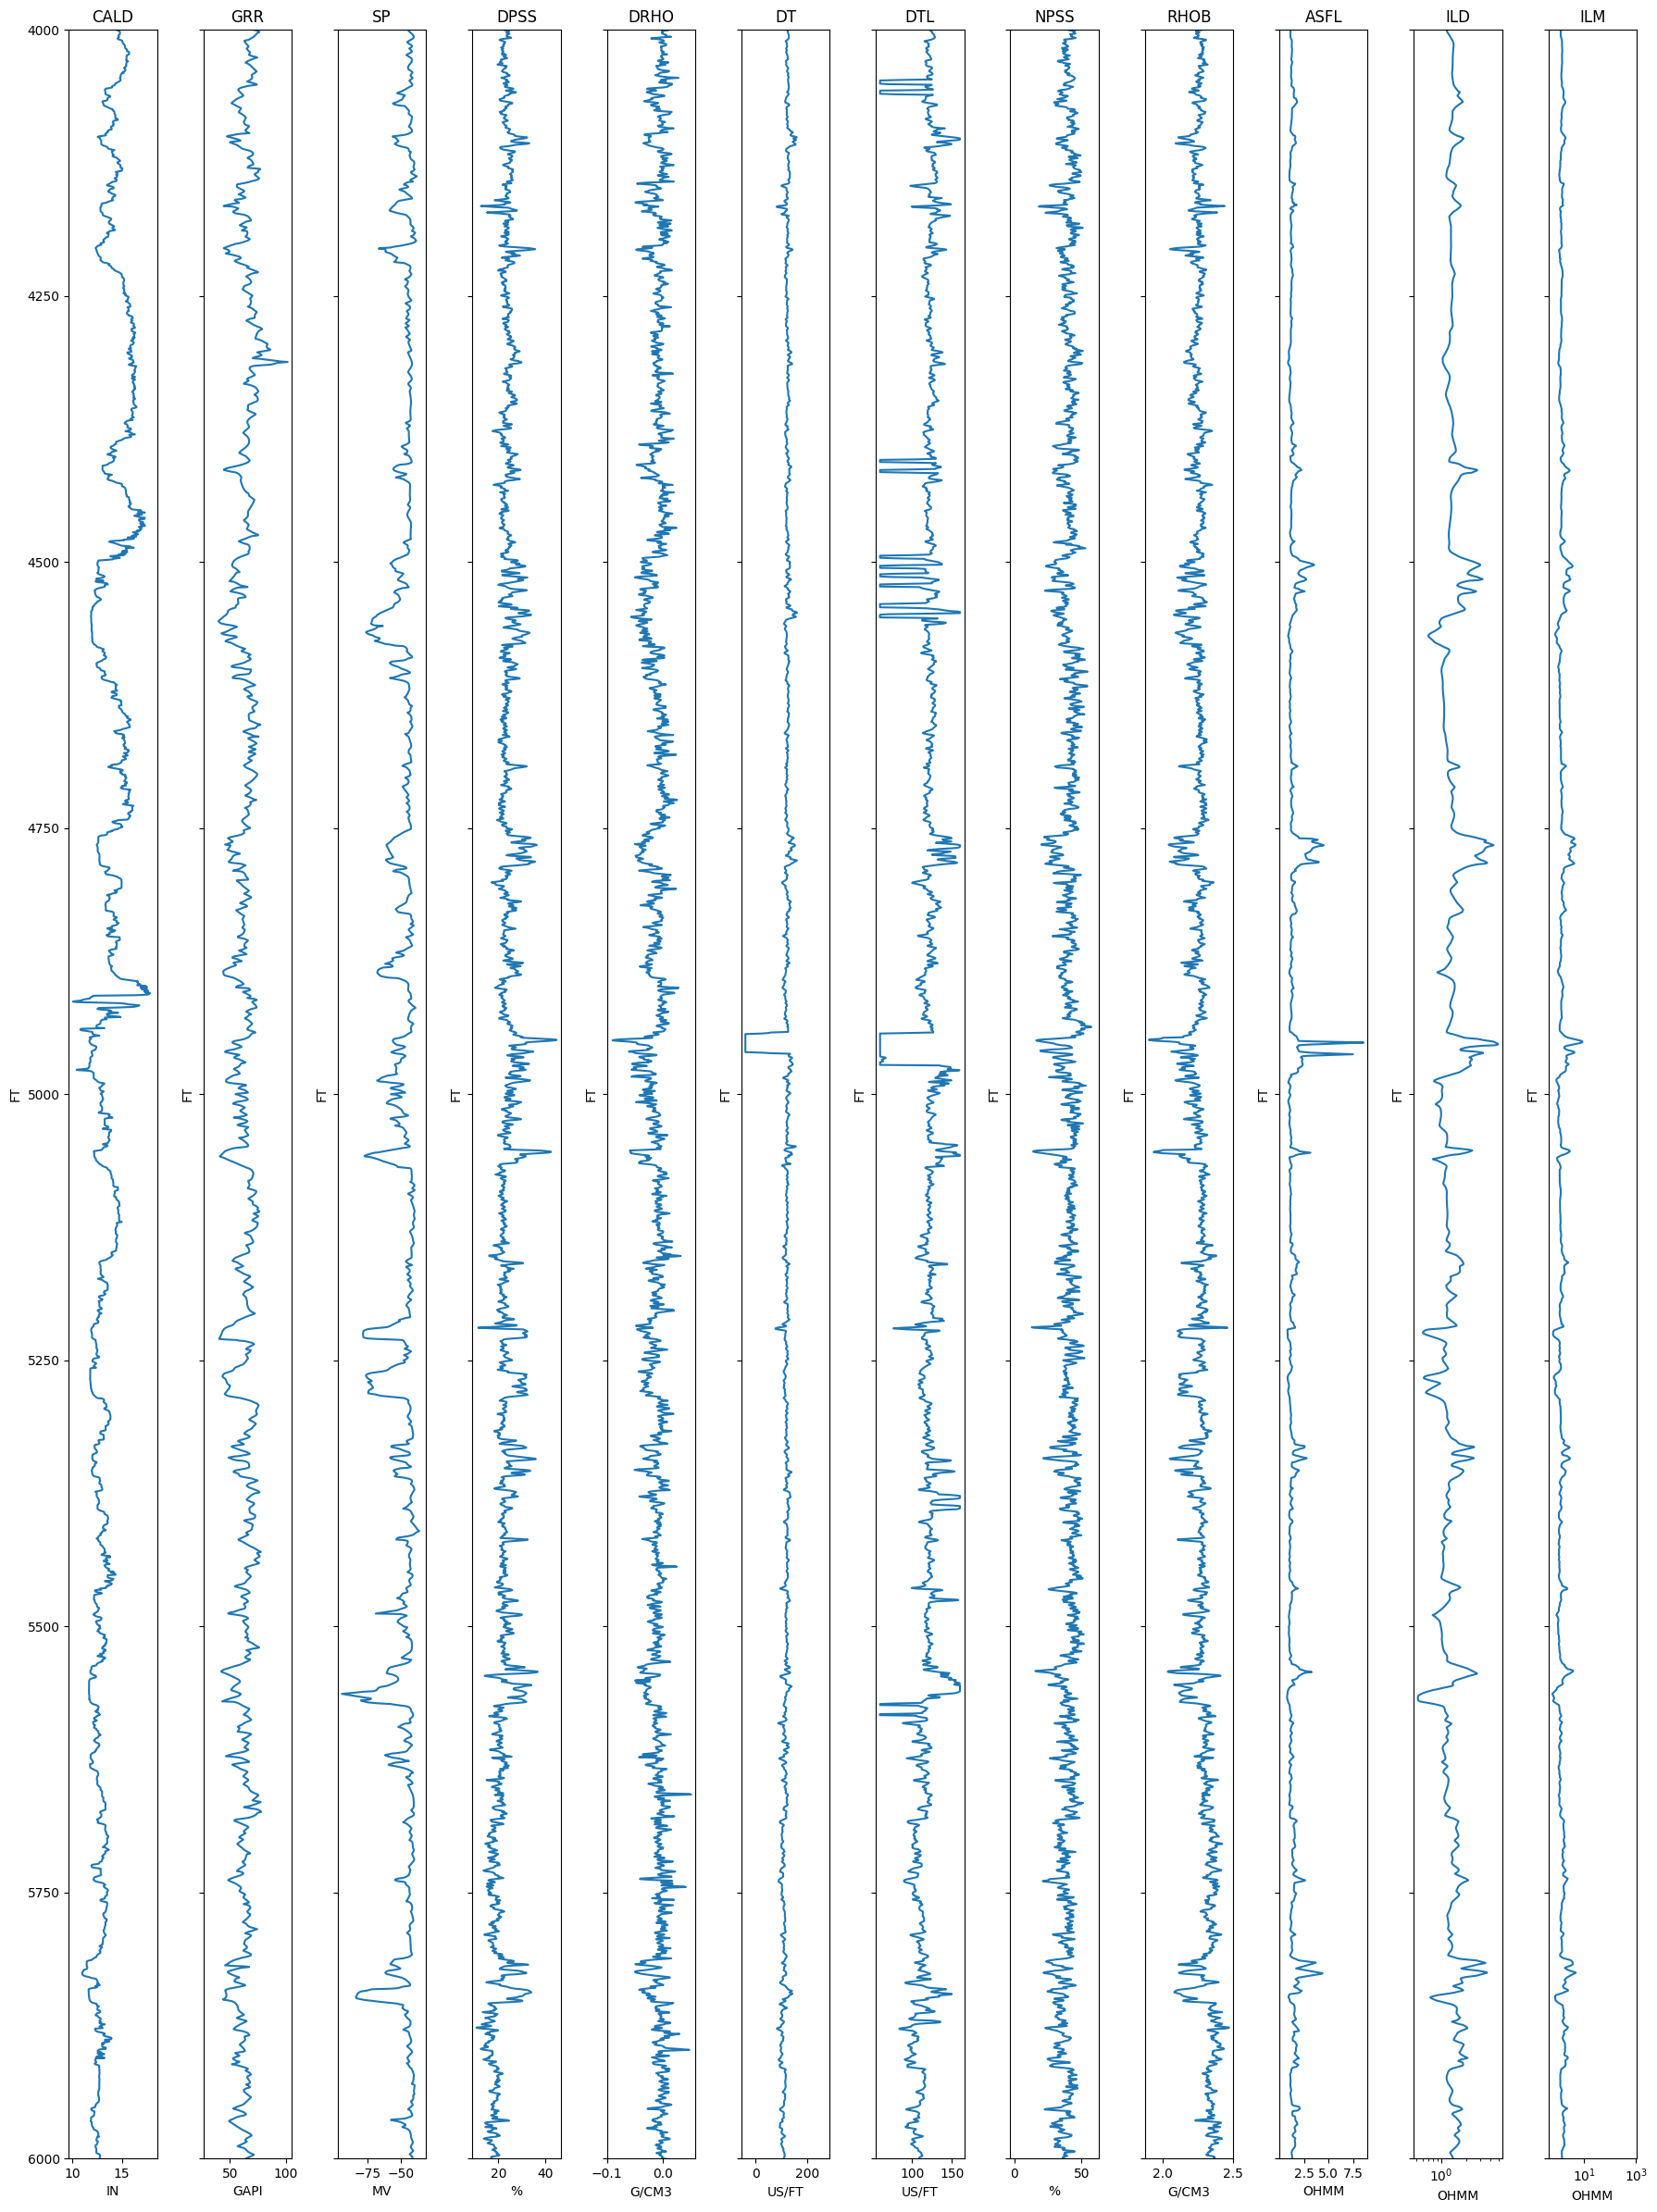

In [8]:
plotter(data)

## Fature Selection based on Mutual Information

We perform feature selection over defined depths using mutual information (Peng et al., 2005; Peng and Fan, 2017) to measure the general pairwise mutual dependence between features and select the conventional well logs (predictor features) with the highest mutual information with the GR well log (response feature). We favor mutual information over correlation analysis for a more flexible measure of information sharing between features, including patterns such as nonlinearity and heteroscedasticity that would negatively impact correlation. 

In [9]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7189 entries, 3586.0 to 7180.0
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CALD    7189 non-null   float64
 1   GRR     7189 non-null   float64
 2   SP      7189 non-null   float64
 3   DPSS    7189 non-null   float64
 4   DRHO    7189 non-null   float64
 5   DT      7189 non-null   float64
 6   DTL     7189 non-null   float64
 7   NPSS    7189 non-null   float64
 8   RHOB    7189 non-null   float64
 9   ASFL    7189 non-null   float64
 10  ILD     7189 non-null   float64
 11  ILM     7189 non-null   float64
dtypes: float64(12)
memory usage: 730.1 KB


In [10]:
Log_to_predict = 'GRR'
#predictors = data.loc[:, data.columns != Log_to_predict]

In [11]:
data['GRR']

DEPT
3586.0    59.7449
3586.5    60.0790
3587.0    60.4165
3587.5    60.9705
3588.0    61.5687
           ...   
7178.0    61.9825
7178.5    62.4615
7179.0    63.0081
7179.5    63.4657
7180.0    63.8083
Name: GRR, Length: 7189, dtype: float64

Feature ranking:
1. feature 1 (1.000000)
2. feature 10 (0.826642)
3. feature 8 (0.799186)
4. feature 9 (0.758792)
5. feature 0 (0.669554)
6. feature 6 (0.534899)
7. feature 7 (0.532823)
8. feature 2 (0.530879)
9. feature 3 (0.510530)
10. feature 5 (0.428641)
11. feature 4 (0.398117)


(-1.0, 11.0)

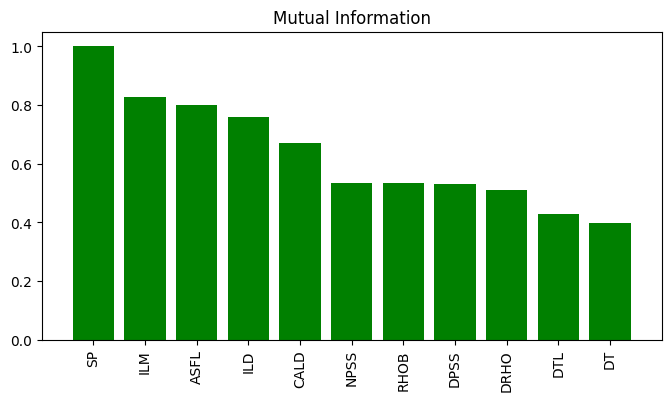

In [12]:
x = data.loc[:,data.columns!=Log_to_predict]
y = data.loc[:,Log_to_predict]

mi = mutual_info_regression(x,np.ravel(y)) # calculate mutual information
imp=mutual_info_regression(x,np.ravel(y))
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], mi[indices[f]]))

#plt.subplot(111)                          # plot the relative mutual information 
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title("Mutual Information")
ax.bar(range(x.shape[1]), mi[indices],
       color="g", align="center")
ax.set_xticks(range(x.shape[1]), x.columns[indices],rotation=90)
ax.set_xlim([-1, x.shape[1]])



## Missing well log imputation


### Predict gamma ray with SP, ASFL and ILD logs

These are common logs with other wells

In [13]:
data.dropna(inplace=True)

In [14]:
well_logs_to_use = ['SP','ASFL','ILD']

In [15]:

X = data.loc[:,well_logs_to_use].values
y = data.loc[:,Log_to_predict].values

ymean = np.mean(y)
ysd = np.std(y)

xmean = np.mean(X)
xsd = np.std(X)

y_transformed = (y-ymean)/ysd


In [16]:
indices = data.index.values

In [17]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y_transformed,indices, test_size=0.33, random_state=42)

In [18]:
import pandas as pd

import torch
from torch import nn
import os
import matplotlib.pyplot as plt

train_x_tr = torch.from_numpy(X_train.reshape([-1,X.shape[1]])).float()
train_y_tr = torch.from_numpy(y_train.reshape([-1,1])).float()
test_x_tr = torch.from_numpy(X_test.reshape([-1,X.shape[1]])).float()
test_y_tr = torch.from_numpy(y_test.reshape([-1,1])).float()
x_tr = torch.from_numpy(X.reshape([-1,X.shape[1]])).float()
y_tr = torch.from_numpy(y_transformed.reshape([-1,1])).float()


In [19]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()

        self.net = torch.nn.Sequential(
        torch.nn.Linear(X.shape[1], 30), #Two features
        torch.nn.LeakyReLU(),

        torch.nn.Linear(30, 30),
        torch.nn.LeakyReLU(),

        torch.nn.Linear(30, 30),
        torch.nn.LeakyReLU(),

        torch.nn.Linear(30, 30),
        torch.nn.LeakyReLU(),
            
        torch.nn.Linear(30,3)
        #torch.nn.Tanh(),
        )

    def forward(self,x):
        return self.net(x)
    
model = Model()
model = model.cuda()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [20]:
def criterion(y_pred, y_target):
    
    ## Quantile Loss
    q1 = 0.1
    q2 = 0.5
    q3 = 0.9
    
    #print(target.shape)
    e1 = y_pred[:,0:1] - y_target # !!! if input[:,0]  -> shape = (1000,)
    e2 = y_pred[:,1:2] - y_target
    e3 = y_pred[:,2:3] - y_target

    eq1 = torch.max(q1*e1, (q1-1)*e1)
    eq2 = torch.max(q2*e2, (q2-1)*e2)
    eq3 = torch.max(q3*e3, (q3-1)*e3)

    loss = (eq1 + eq2 + eq3).mean()

    return loss
    
train_x_tr = train_x_tr.cuda()    
train_y_tr = train_y_tr.cuda()

# If model exists then load the state dict
if os.path.isfile('Well_log_model.pth'):
    model.load_state_dict(torch.load('Well_log_model.pth'))
    print('Model loaded from file')

for step in range(15000):
    
    y_preds = model(train_x_tr)
    loss = criterion(y_preds, train_y_tr)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step+1) % 500 == 0:
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

torch.save(model.state_dict(), 'Well_log_model.pth')

epoch 500 loss=0.4655
epoch 1000 loss=0.4315
epoch 1500 loss=0.4248
epoch 2000 loss=0.4286
epoch 2500 loss=0.4208
epoch 3000 loss=0.4196
epoch 3500 loss=0.4185
epoch 4000 loss=0.4173
epoch 4500 loss=0.4163
epoch 5000 loss=0.4159
epoch 5500 loss=0.4157
epoch 6000 loss=0.4154
epoch 6500 loss=0.4139
epoch 7000 loss=0.4101
epoch 7500 loss=0.4041
epoch 8000 loss=0.4006
epoch 8500 loss=0.3984
epoch 9000 loss=0.3961
epoch 9500 loss=0.4139
epoch 10000 loss=0.3939
epoch 10500 loss=0.3879
epoch 11000 loss=0.3983
epoch 11500 loss=0.3869
epoch 12000 loss=0.405
epoch 12500 loss=0.3837
epoch 13000 loss=0.397
epoch 13500 loss=0.3827
epoch 14000 loss=0.3823
epoch 14500 loss=0.3816
epoch 15000 loss=0.383


In [21]:
#train
y_pred_train = model(train_x_tr.cuda())
y_pred_train_back = ysd*y_pred_train+ymean
yqs_train = y_pred_train_back.detach().cpu().numpy()

#test
y_pred_test = model(test_x_tr.cuda())
y_pred_test_back = ysd*y_pred_test+ymean
yqs_test = y_pred_test_back.detach().cpu().numpy()

# all data
y_pred = model(x_tr.cuda())
y_pred_back = ysd*y_pred+ymean
yqs = y_pred_back.detach().cpu().numpy()

We obtain similar errors between training and testing

In [22]:
#calculate MSE between predicted and actual
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(yqs_train[:,1], y_train)
mse_test = mean_squared_error(yqs_test[:,1], y_test)
print(f'MSE train = {mse_train:4.1f}')
print(f'MSE test = {mse_test:4.1f}')

MSE train = 4251.4
MSE test = 4246.9


Now lets plot the quantile predictions with respect to depth

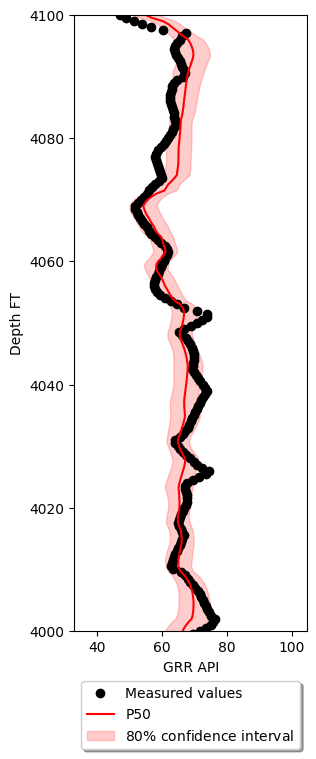

In [23]:
# Plot the results where yqs is the quantile predictions
fig, ax = plt.subplots(figsize=(3, 8))
ax.plot(y,data.index,'ko', label='Measured values')
ax.plot(yqs[:,1],data.index,'r-', label='P50')

# color between yqs[:,0] and yqs[:,2]
ax.fill_betweenx(data.index, yqs[:,0], yqs[:,2], color='r', alpha=0.2, label='80$\%$ confidence interval')
# ax.plot(yqs[:,1],data.index,'r-', label='P50')
# ax.plot(yqs[:,1],data.index,'r-', label='P50')

ax.set_xlabel('GRR API')
ax.set_ylabel('Depth FT')
ax.invert_yaxis()
ax.set_ylim(4000,4100)
#ax.invert_yaxis()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
            fancybox=True, shadow=True, ncol=1)


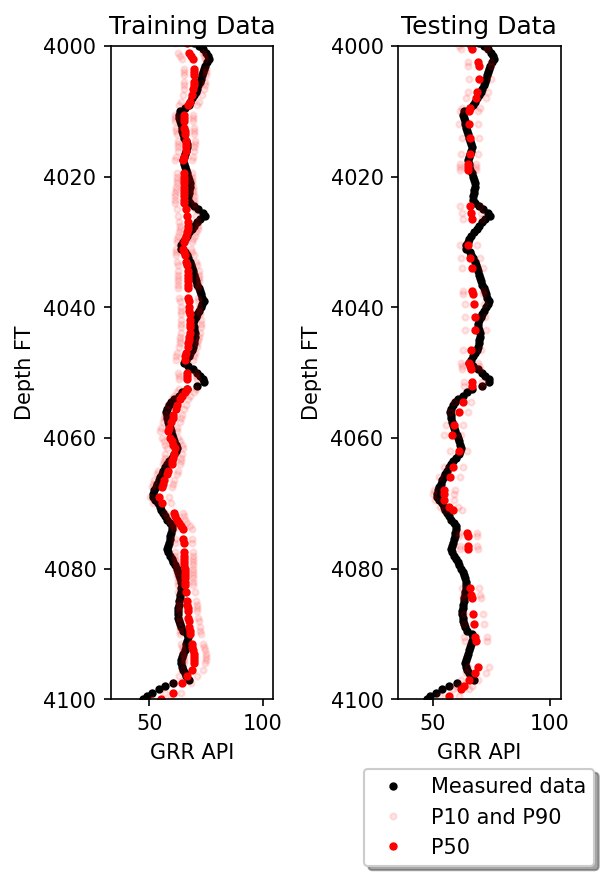

In [24]:
fig, axs = plt.subplots(1,2,figsize=(4,6),dpi=150)
ax = axs[0]
ax.set_title('Training Data')
ax.plot(data['GRR'],data.index,'k.')
ax.plot(yqs_train[:,0],idx_train, '.r',alpha = 0.1)
ax.plot(yqs_train[:,1],idx_train, 'r.', linewidth=1)
ax.plot(yqs_train[:,2],idx_train, '.r',alpha = 0.1)
ax.set_xlabel('GRR API')
ax.set_ylabel('Depth FT')
ax.invert_yaxis()
ax.set_ylim(4000,4100)
ax.invert_yaxis()

ax = axs[1]
ax.set_title('Testing Data')
ax.plot(data['GRR'],data.index,'k.',label = 'Measured data')
ax.plot(yqs_test[:,0],idx_test, '.r',alpha = 0.1, label = 'P10 and P90')
ax.plot(yqs_test[:,1],idx_test, 'r.', linewidth=1, label = 'P50')
ax.plot(yqs_test[:,2],idx_test, '.r',alpha = 0.1)
ax.set_xlabel('GRR API')
ax.set_ylabel('Depth FT')
ax.invert_yaxis()
ax.set_ylim(4000,4100)
ax.invert_yaxis()

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09),
            fancybox=True, shadow=True, ncol=1)

fig.tight_layout()

### Performance in other well logs
We select a second well log from a different well and we try to generate the GR log using the previous model

In [25]:
las = lasio.read(las_files[15])
#data = las.df().reset_index() # Transform to pandas dataframe, reset index so depth is not the index
data_2 = las.df()

In [26]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 22625 entries, 1348.0 to 12660.0
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GR:1    5245 non-null   float64
 1   NPHI    21888 non-null  float64
 2   AILD    16884 non-null  float64
 3   ASFL    7331 non-null   float64
 4   CILD    16888 non-null  float64
 5   GR:2    17534 non-null  float64
 6   ILD     16816 non-null  float64
 7   SFL     16838 non-null  float64
 8   SP      16883 non-null  float64
 9   CALI    16695 non-null  float64
 10  DRHO    16669 non-null  float64
 11  GR:3    16713 non-null  float64
 12  RHOB    16691 non-null  float64
 13  DT      16824 non-null  float64
dtypes: float64(14)
memory usage: 2.6 MB


In [27]:
#Obtain a subset from the dataframe given column names
data_2_subset = data_2[well_logs_to_use].copy()
data_2_subset.dropna(inplace=True)

In [28]:
data_2_subset.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7263 entries, 8685.0 to 12343.0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP      7263 non-null   float64
 1   ASFL    7263 non-null   float64
 2   ILD     7263 non-null   float64
dtypes: float64(3)
memory usage: 227.0 KB


In [29]:
X_2 = data_2_subset.loc[:,well_logs_to_use].values
x_tr = torch.from_numpy(X_2.reshape([-1,X_2.shape[1]])).float()

In [30]:
y_pred = model(x_tr.cuda())
y_pred_back = ysd*y_pred+ymean
yqs = y_pred_back.detach().cpu().numpy()

(0.0, 100.0)

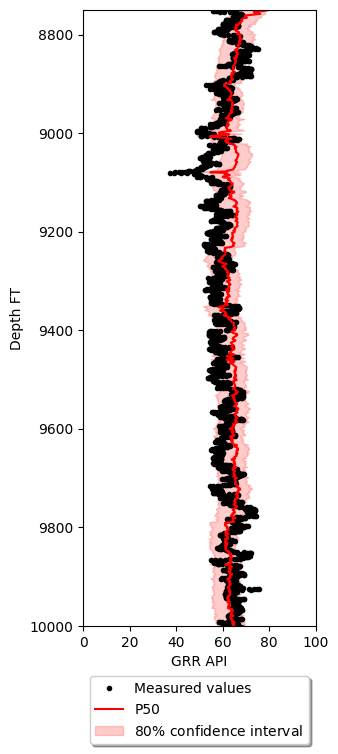

In [31]:
# Plot the results where yqs is the quantile predictions
fig, ax = plt.subplots(figsize=(3, 8))
ax.plot(data_2['GR:3'],data_2.index,'k.', label='Measured values')
ax.plot(yqs[:,1],data_2_subset.index,'r-', label='P50')

ax.fill_betweenx(data_2_subset.index, yqs[:,0], yqs[:,2], color='r', alpha=0.2, label='80$\%$ confidence interval')

ax.set_xlabel('GRR API')
ax.set_ylabel('Depth FT')
ax.invert_yaxis()
ax.set_ylim(8750,10000)
ax.invert_yaxis()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
            fancybox=True, shadow=True, ncol=1)
ax.set_xlim(0,100)

### Key takeaways
- The uncertainty estimation is limited to the uncertainty present in the training data
- More features can be explored
- Use multiple correlated wells to perform training